# House Pricing Analysis- ML

**Work Flow** 
- House Price Data
- Data Pre-Processing
- Data Analysis
- Train Test Split
- XGBoost Regressor
- Evaluation

**Import libraries**

In [249]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.datasets
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

**Load in Data California**

In [250]:
house_data = pd.read_csv('data/Housing.csv')

In [251]:
house_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [252]:
# check for shape of dataframe
house_data.shape

(545, 13)

In [253]:
# check for missing values 
print(house_data.isnull().sum())
print(house_data.dtypes)

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64
price                int64
area                 int64
bedrooms             int64
bathrooms            int64
stories              int64
mainroad            object
guestroom           object
basement            object
hotwaterheating     object
airconditioning     object
parking              int64
prefarea            object
furnishingstatus    object
dtype: object


In [254]:
# label encode categorical columns dtype = objects
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_encoded_df = house_data.copy()
for col in label_encoded_df.select_dtypes(include='O').columns:
    label_encoded_df[col]=le.fit_transform(label_encoded_df[col])
label_encoded_df.head()
# For Categorical collumns
# 1 = Yes 0 = No
# Furnishing 0 = F, 1 = PF, 2 = NF

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,0
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,1
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,0
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,0
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,0
5,10850000,7500,3,3,1,1,0,1,0,1,2,1,1
9,9800000,5750,3,2,4,1,1,0,0,1,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,2
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,1
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,2
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,0


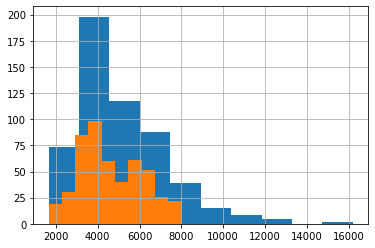

In [274]:
# check distribution of data
encoded_df = label_encoded_df.copy()
encoded_df['area'].hist()
# removing outliers to give better normal distribution data
encoded_df = encoded_df.drop(encoded_df[encoded_df.area > 8000].index)
#drop low affecting feautres reducing complexity of model
encoded_df['area'].hist()
encoded_df

**Understanding the data (correlations)**

In [275]:
correlation = encoded_df.corr()

<AxesSubplot:>

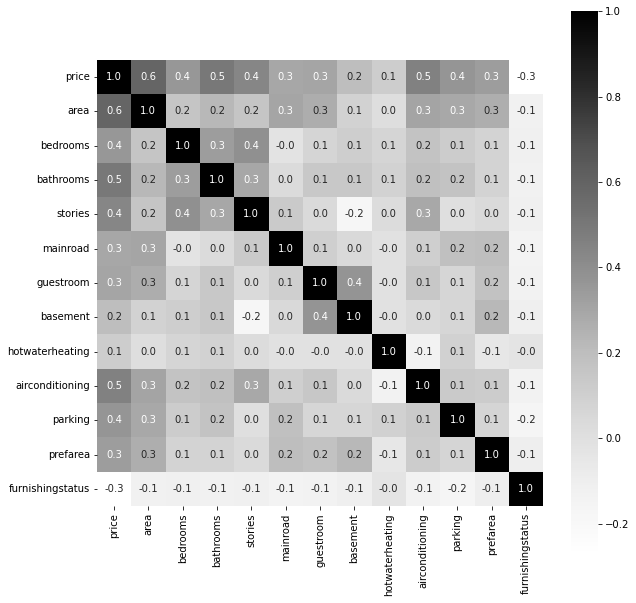

In [276]:
# construct heatmap to display correlation
plt.figure(figsize= (10, 10))
sns.heatmap(correlation, cbar = True, square= True, fmt = '.1f', annot= True, annot_kws= {'size':10}, cmap = 'Greys')

In [277]:
#Splitting DataFrame into X(predictors), and y (target)
X = encoded_df.drop(['price'], axis = 1)
y = encoded_df['price']
print(X.head())
print(y.head())

   area  bedrooms  bathrooms  stories  mainroad  guestroom  basement  \
0  7420         4          2        3         1          0         0   
3  7500         4          2        2         1          0         1   
4  7420         4          1        2         1          1         1   
5  7500         3          3        1         1          0         1   
9  5750         3          2        4         1          1         0   

   hotwaterheating  airconditioning  parking  prefarea  furnishingstatus  
0                0                1        2         1                 0  
3                0                1        3         1                 0  
4                0                1        2         0                 0  
5                0                1        2         1                 1  
9                0                1        1         1                 2  
0    13300000
3    12215000
4    11410000
5    10850000
9     9800000
Name: price, dtype: int64


In [278]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_scaled = min_max_scaler.fit_transform(X)

X_df = pd.DataFrame(X_scaled, columns=X.columns)
X_df.describe()

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000
mean,0.472187,0.389837,0.136179,0.267615,0.843496,0.180894,0.351626,0.048780,0.304878,0.205285,0.223577,0.552846
std,0.235623,0.147133,0.238273,0.282985,0.363702,0.385322,0.477964,0.215628,0.460824,0.275086,0.417066,0.377919
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.291339,0.200000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
50%,0.425354,0.400000,0.000000,0.333333,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000
75%,0.685039,0.400000,0.500000,0.333333,1.000000,0.000000,1.000000,0.000000,1.000000,0.333333,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Split Data into Train and Test**

In [279]:
X_train, X_test, y_train, y_test = train_test_split(X_df,y, test_size = 1/3, random_state = 20)
X_train

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
346,0.288189,0.4,0.0,0.000000,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,1.0
185,0.735591,0.4,0.0,0.333333,1.0,0.0,1.0,0.0,1.0,0.333333,0.0,0.0
276,0.311811,0.4,0.5,0.333333,1.0,0.0,0.0,1.0,0.0,0.666667,0.0,0.5
318,0.311811,0.2,0.0,0.000000,1.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0
175,0.471811,0.4,0.0,0.333333,1.0,1.0,1.0,0.0,0.0,0.666667,0.0,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...
412,0.448819,0.2,0.0,0.333333,1.0,0.0,0.0,1.0,0.0,0.333333,0.0,0.5
223,0.508661,0.4,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.666667,1.0,1.0
271,0.669291,0.6,0.5,0.333333,0.0,0.0,1.0,0.0,0.0,0.333333,0.0,1.0
474,0.029291,0.2,0.0,0.000000,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.5


In [280]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(328, 12) (164, 12) (328,) (164,)


**Model Training**

*XGBoost Regressor (kind of a Decision Tree Ensemble Model)*

In [281]:
#loading Model
model_xgb = XGBRegressor()


In [282]:
#train model with X_train
model_xgb.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.300000012, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=6, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

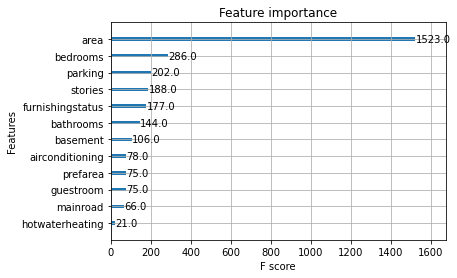

In [283]:
import xgboost as xgb

%matplotlib inline
xgb.plot_importance(model_xgb, ax = plt.gca())


In [284]:
training_data_prediction = model_xgb.predict(X_train)

**Evaluation**

In [285]:
#Prediction on training data
#accracy for prediction on training data

# R squared error
score_1 = metrics.r2_score(y_train, training_data_prediction)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(y_train, training_data_prediction)

print("R squared error : ", score_1)
print('Mean Absolute Error : ', score_2)

R squared error :  0.9980067173426242
Mean Absolute Error :  36799.79649390244


In [286]:
# Visualise Acutal vs Predictied Train

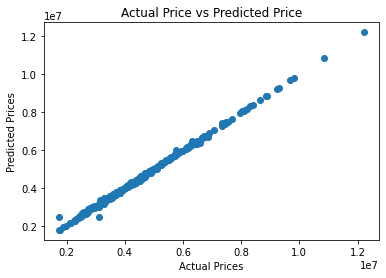

In [287]:
plt.scatter(y_train, training_data_prediction)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Price vs Predicted Price')
plt.show()

In [288]:
#Prediction on test data
test_data_prediction = model_xgb.predict(X_test)
#accracy for prediction on test data

# R squared error
score_1 = metrics.r2_score(y_test, test_data_prediction)

# Mean Absolute Error
score_2 = metrics.mean_absolute_error(y_test, test_data_prediction)

print("R squared error : ", score_1)
print('Mean Absolute Error : ', score_2)

R squared error :  0.6295090864217208
Mean Absolute Error :  844883.6074695121


In [289]:
print (test_data_prediction[0:5] , y_test.iloc[0:5])

[3475842.8 4250868.  5769585.  3431655.  3315348.5] 189    5040000
434    3290000
250    4515000
400    3500000
430    3290000
21     8680000
370    3640000
144    5600000
40     7875000
264    4410000
Name: price, dtype: int64


In [291]:
# Visualise Acutal vs Predictied Test

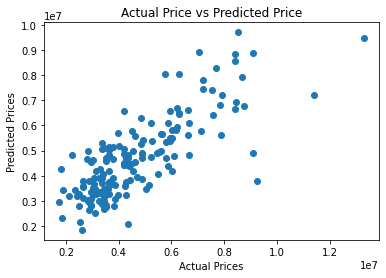

In [292]:
plt.scatter(y_test, test_data_prediction)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual Price vs Predicted Price')
plt.show()